# Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
# First, import the relevant modules
import requests
import collections
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')


In [2]:
# load data: login.json
df_logins = pd.read_json('logins.json')
# look firts five entries of the dataframe
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df_logins.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


We have longin record from Janaury 01, 1970 till April 13, 1970 in increments of 15 minutes. A login record of 4 months in the begining of 1970. 

In [4]:
# How many login records do we have? df_logins.shape
df_logins.shape

(93142, 1)

We have 93142 login records over the period of 4 months. 

In [5]:
# Get column information and check if there are any missing values
df_logins.info()
df_logins.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


login_time    0
dtype: int64

We do not have any nan values and we have a column of type datatime

In [6]:
# create a column to count logins: login_count
df_logins['login_count'] = 1
df_logins.head()

,login_time,login_count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [7]:
# Reset index of dataframe to login_time
df_logins.set_index('login_time',inplace=True)
df_logins.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [8]:
# Aggregate these login counts based on 15­minute time intervals
df_15min_aggregated = df_logins.resample('15min').sum()
df_15min_aggregated.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [9]:
# Reset index of df_aggregated dataframe
df_15min_aggregated.reset_index(inplace=True)
df_15min_aggregated.head()


,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


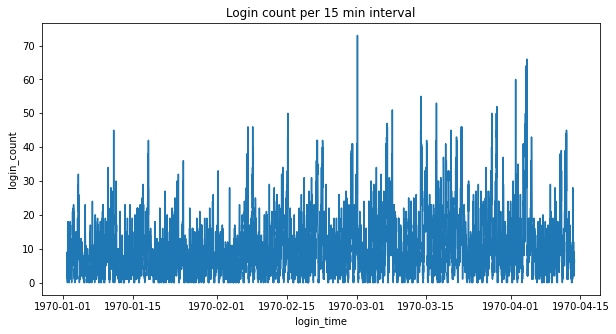

In [10]:
# visualize and describe the resulting time series of login counts
ax, fig = plt.subplots(figsize=[10,5])
sns.lineplot(x='login_time',y='login_count',data=df_15min_aggregated)
plt.title('Login count per 15 min interval')
#plt.figure(figsize=(20,20))
plt.show()

Login data shows hourly,daily, weekly, and monthly variation. These variations can be visualized by decomponsing `login_time` data feature into separate hourly, daily, monthly feature columns. In what follows below we create features named `time`, `min`, `hour`, `day`, `week`, and `month`.

In [11]:
# Create new feature columns to store login time, hour, minute, day, week, weekday, month
df_15min_aggregated['time'] = df_15min_aggregated['login_time'].dt.time
df_15min_aggregated['min'] = df_15min_aggregated['login_time'].dt.minute
df_15min_aggregated['hour'] = df_15min_aggregated['login_time'].dt.hour
df_15min_aggregated['day_name'] = df_15min_aggregated['login_time'].dt.day_name()
df_15min_aggregated['week'] = df_15min_aggregated['login_time'].dt.week
df_15min_aggregated['month'] = df_15min_aggregated['login_time'].dt.month
df_15min_aggregated['day'] = df_15min_aggregated['login_time'].dt.day

In [12]:
df_15min_aggregated.head()

,login_time,login_count,time,min,hour,day_name,week,month,day
0,1970-01-01 20:00:00,2,20:00:00,0,20,Thursday,1,1,1
1,1970-01-01 20:15:00,6,20:15:00,15,20,Thursday,1,1,1
2,1970-01-01 20:30:00,9,20:30:00,30,20,Thursday,1,1,1
3,1970-01-01 20:45:00,7,20:45:00,45,20,Thursday,1,1,1
4,1970-01-01 21:00:00,1,21:00:00,0,21,Thursday,1,1,1


## Analysis of login activity every 15 minute interval 

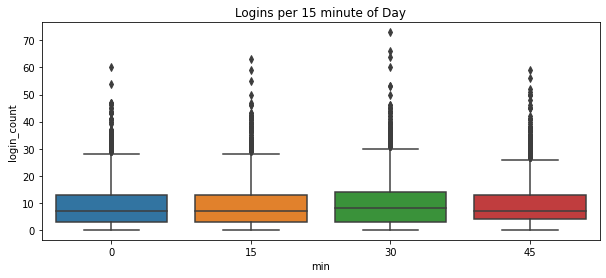

In [13]:
ax, fig = plt.subplots(figsize=[10,4])
sns.boxplot(data=df_15min_aggregated, x='min', y='login_count')
plt.title('Logins per 15 minute of Day');

Login spread is almost constant over a period of 15 minutes in every hour. 

(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '15'), Text(2, 0, '30'), Text(3, 0, '45')])

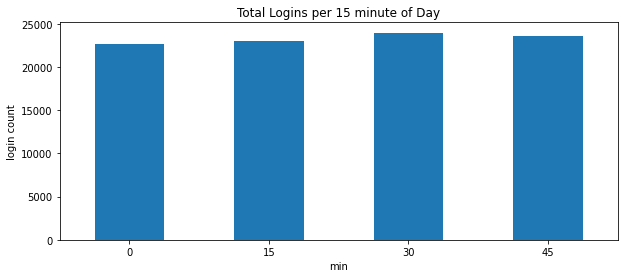

In [14]:
df_minute = df_15min_aggregated.groupby('min')['login_count'].sum()
df_minute.plot(kind='bar',figsize=(10,4))
plt.ylabel('login count')
plt.title('Total Logins per 15 minute of Day');
plt.xticks(rotation=0)

The total number of logins per 15 minute interval is almost constant throughout every hoour.

## Hourly login activity

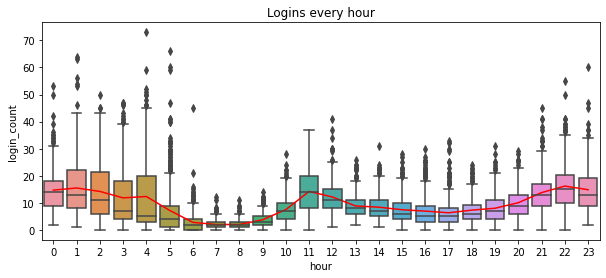

In [15]:
fig,ax = plt.subplots(figsize=[10,4])
df_15min_aggregated.groupby(['hour'])['login_count'].mean().plot(title = "Login Count by Time",ax=ax,color='red')
sns.boxplot(data=df_15min_aggregated, x='hour', y='login_count',ax=ax)
plt.title('Logins every hour');

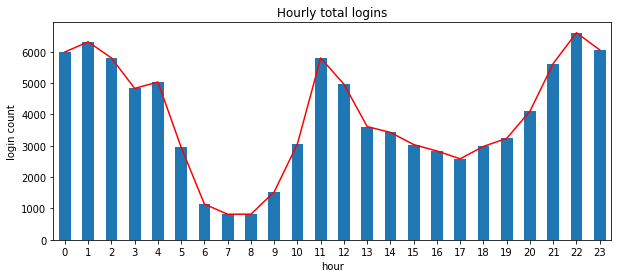

In [16]:
fig,ax = plt.subplots(figsize=[10,4])
df_15min_aggregated.groupby(['hour'])['login_count'].sum().plot(title = "Login Count by Time",ax=ax,color='red')
df_hour = df_15min_aggregated.groupby('hour')['login_count'].sum()
df_hour.plot(kind='bar',figsize=(10,4),ax=ax)
plt.ylabel('login count')
plt.title('Hourly total logins');
plt.xticks(rotation=0);

## Daily login activity

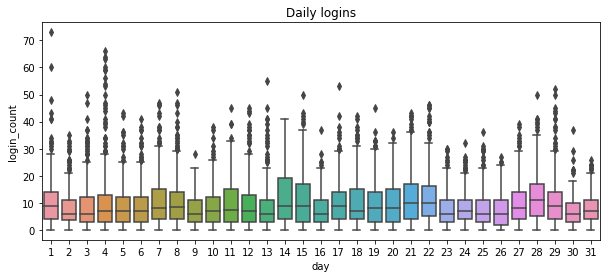

In [17]:
ax, fig = plt.subplots(figsize=[10,4])
sns.boxplot(data=df_15min_aggregated, x='day', y='login_count')
plt.title('Daily logins');

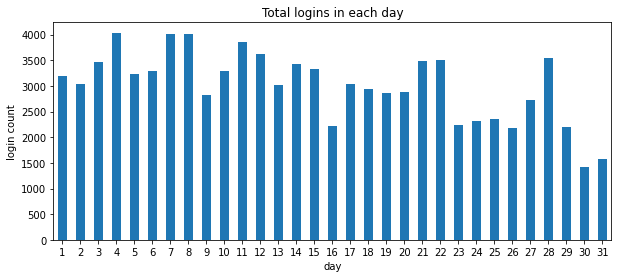

In [18]:
df_daily = df_15min_aggregated.groupby(['day'])['login_count'].sum()
df_daily.plot(kind='bar',figsize =(10,4))
plt.ylabel('login count')
plt.title('Total logins in each day');
plt.xticks(rotation=0);

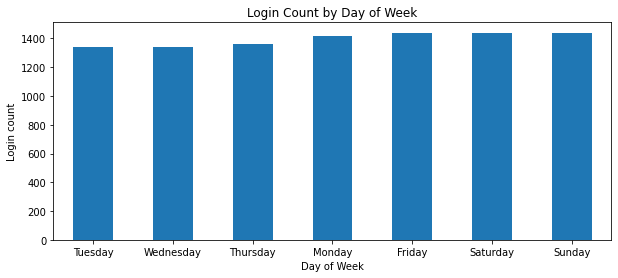

In [19]:
df_day_name = df_15min_aggregated.groupby(['day_name'])['login_count'].count().sort_values()
df_day_name.plot(kind='bar', title="Login Count by Day of Week",figsize=(10,4))
plt.xticks(rotation=0)
plt.xlabel('Day of Week')
plt.ylabel('Login count');

## Weekly logins

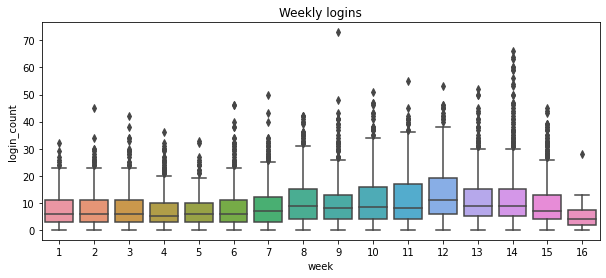

In [20]:
ax, fig = plt.subplots(figsize=[10,4])
sns.boxplot(data=df_15min_aggregated, x='week', y='login_count')
plt.title('Weekly logins');

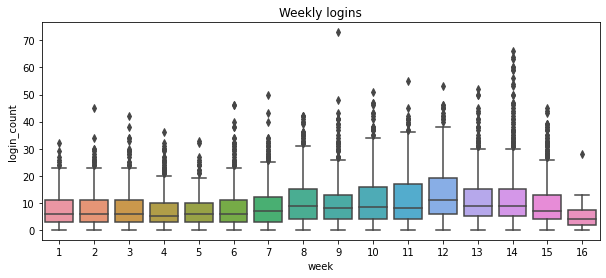

In [21]:
ax, fig = plt.subplots(figsize=[10,4])
sns.boxplot(data=df_15min_aggregated, x='week', y='login_count')
plt.title('Weekly logins');

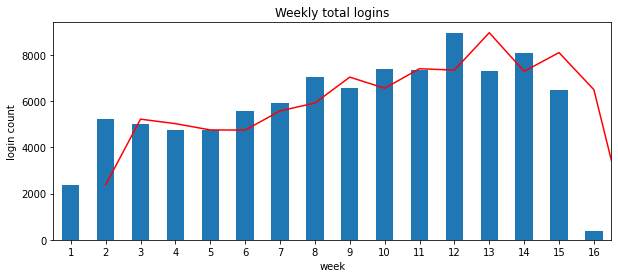

In [22]:
fig,ax = plt.subplots(figsize=[10,4])
#df_15min_aggregated.groupby(['day'])['login_count'].sum().plot(ax=ax,color='red')
df_weekly = df_15min_aggregated.groupby('week')['login_count'].sum()
df_weekly.plot(ax=ax,color='red')
df_weekly.plot(kind='bar',ax=ax,figsize=(10,4))
plt.ylabel('login count')
plt.title('Weekly total logins');
plt.xticks(rotation=0);

## Monthly logins

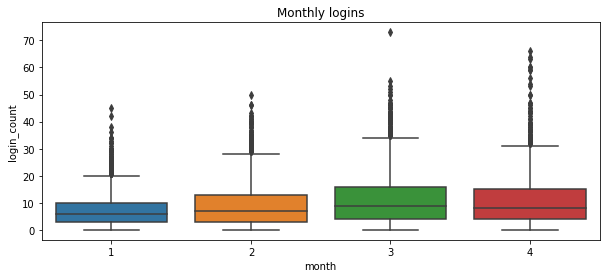

In [23]:
ax, fig = plt.subplots(figsize=[10,4])
sns.boxplot(data=df_15min_aggregated, x='month', y='login_count')
plt.title('Monthly logins');

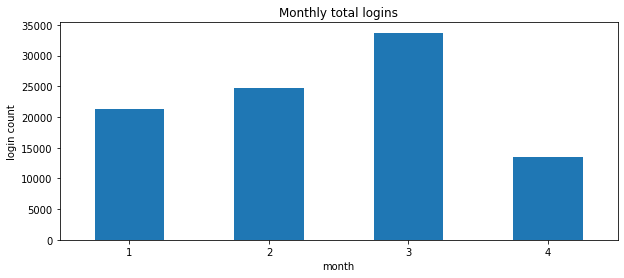

In [24]:
fig,ax = plt.subplots(figsize=[10,4])
df_monthly = df_15min_aggregated.groupby('month')['login_count'].sum()
df_monthly.plot(kind='bar',ax=ax)
plt.ylabel('login count')
plt.title('Monthly total logins');
plt.xticks(rotation=0);

# Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

Summary:

- Two cities (Gotham and Metropolis) with complementary circadian rythms.
- Gotham - most active during `night`
- Metropolis - most active during `day`
- Weekends - reasonable activity on both

Problem:
- Toll bridge (toll cost) - forces drivers to be exclusively active in one city

Proposal solution:
- Re-imburse toll cost to encourage drivers to work equally in the two cities.

\textbf{Answer:} 

- I choose the ratio of total re-imbursed toll cost to total cost as a key measure to encourage driver partners serve both cities. The larger the ratio means more drivers have been serving in both cities. The larger the ratio indicates success in the experiment. 

- I would choose statistical hypothesis test to verify the statistical significance of the experiment. The null hypothesis would be the ratio does not have an impact more drivers driving in both cities. 


# Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).

Data description:
- `city`: city this user signed up in
- `phone`: primary device for this user
- `signup_date`: date of account registration; in the form ‘YYYYMMDD’
- `last_trip_date`: the last time this user completed a trip; in the form ‘YYYYMMDD’
- `avg_dist`: the average distance in miles per trip taken in the first 30 days after signup
- `avg_rating_by_driver`: the rider’s average rating over all of their trips
- `avg_rating_of_driver`: the rider’s average rating of their drivers over all of their trips
- `surge_pct`: the percent of trips taken with surge multiplier > 1
- `avg_surge`: The average surge multiplier over all of this user’s trips
- `trips_in_first_30_days`: the number of trips this user took in the first 30 days after
signing up
- `ultimate_black_user`: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
- `weekday_pct`: the percent of the user’s trips occurring during a weekda

In [25]:
# read json file into a data frame: df
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [26]:
df.shape

(50000, 12)

## Explore the data set
### Number of missing values by column

In [27]:
# Get the number of features in dataset.
print('Data set has %d features' % len(df.columns))
df.columns

Data set has 12 features


Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [28]:
# get number of missing values by column
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=True)

,count,%
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
surge_pct,0,0.000
ultimate_black_user,0,0.000
weekday_pct,0,0.000
avg_dist,0,0.000
avg_rating_by_driver,201,0.402


We have missing values in our dataset. Only three features out 12 contain missing values. Feature `avg_rating_of_driver` has the largest number of missing values. 

### Explore data type of features

In [29]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

Our dataset consist of mixed data type features. 

#### Categorical features

In [30]:
df.select_dtypes('object')

,city,signup_date,last_trip_date,phone
0,King's Landing,2014-01-25,2014-06-17,iPhone
1,Astapor,2014-01-29,2014-05-05,Android
2,Astapor,2014-01-06,2014-01-07,iPhone
3,King's Landing,2014-01-10,2014-06-29,iPhone
4,Winterfell,2014-01-27,2014-03-15,Android
...,...,...,...,...
49995,King's Landing,2014-01-25,2014-06-05,iPhone
49996,Astapor,2014-01-24,2014-01-25,iPhone
49997,Winterfell,2014-01-31,2014-05-22,Android
49998,Astapor,2014-01-14,2014-01-15,iPhone


We need to change the `signup_date` and `last_trip_date` into datetime type. 

In [31]:
# Convert date deature to datetime 
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [32]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [33]:
categorical_features = ['city', 'phone', 'ultimate_black_user']

#### Categorical feature bar plot

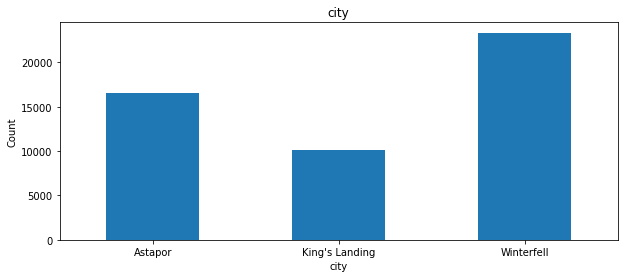

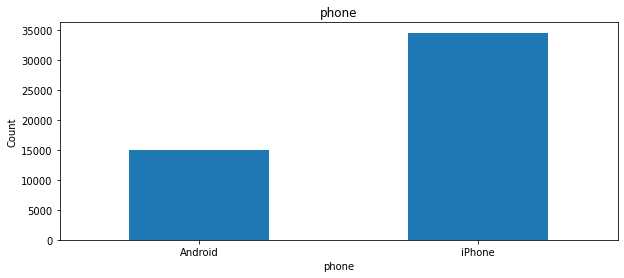

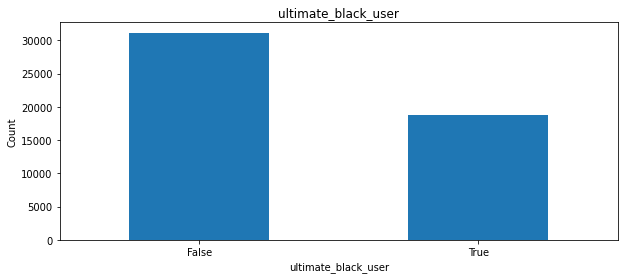

In [34]:
for feature in categorical_features:
    fig,ax = plt.subplots(figsize=[10,4])
    df_cat = df.groupby([feature])[feature].count()
    df_cat.plot(kind='bar',ax=ax)
    plt.ylabel('Count')
    plt.title(feature);
    plt.xticks(rotation=0);

#### Numerical Features

In [35]:
# get numerical feature column names
n1 = list(df.select_dtypes('float64').columns)
n2 = list(df.select_dtypes('int64').columns)
numerical_features = n1 + n2
print(numerical_features)

['avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'trips_in_first_30_days']


#### Distribution of Numerical features

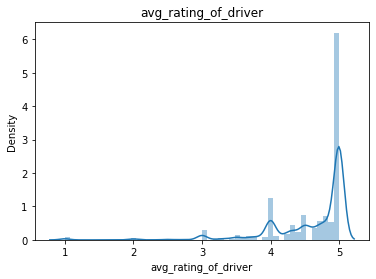

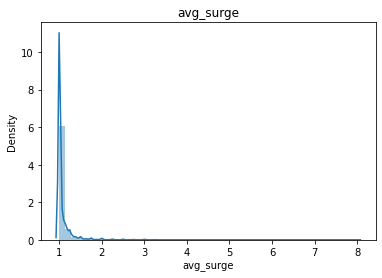

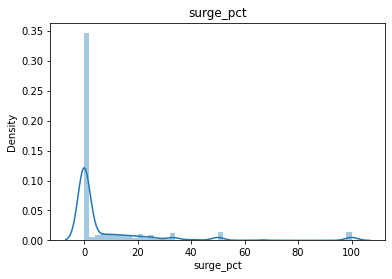

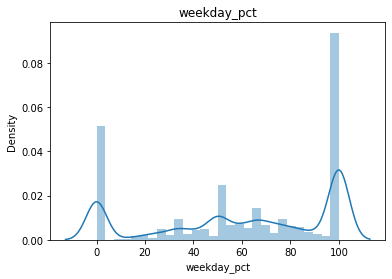

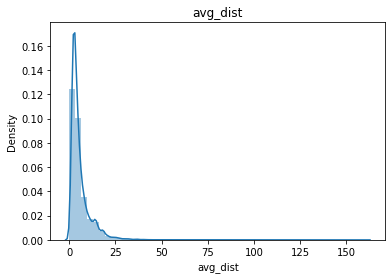

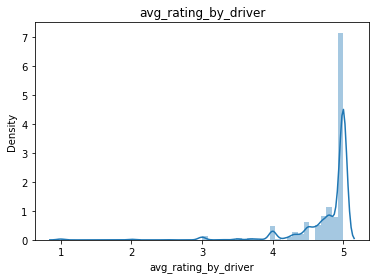

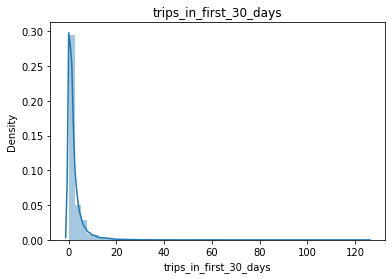

In [36]:
for feature in numerical_features:
    sns.distplot(df[feature])
    plt.title(feature)
    plt.show();

### Missing values revist
The missing values are only a small fraction of the dataset and are related to `driver rating`. Hence, it would be safe to drop the missing values.

In [37]:
df.shape

(50000, 12)

In [38]:
df_NaN_free = df.dropna().copy()
df_NaN_free.shape

(41445, 12)

In [39]:
df_NaN_free.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

### Feature engineering
 we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We need to create a new feature named `retained` with values 1 and 0 depending on whether they took a trip in a month or not. 

In [40]:
# Get the latest last trip
df_NaN_free['last_trip_date'].sort_values().tail()

27068   2014-07-01
15733   2014-07-01
3397    2014-07-01
21753   2014-07-01
31481   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

The latest last trip in our dataset is `2014-07-11`. We consider a user active if he/she has taken a trip in at least the preceeding last 30 days.

In [41]:
df_NaN_free['retained'] = (df_NaN_free.last_trip_date >= (df_NaN_free.last_trip_date.max()-dt.timedelta(30)))*1

In [42]:
df_NaN_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41445 non-null  object        
 1   trips_in_first_30_days  41445 non-null  int64         
 2   signup_date             41445 non-null  datetime64[ns]
 3   avg_rating_of_driver    41445 non-null  float64       
 4   avg_surge               41445 non-null  float64       
 5   last_trip_date          41445 non-null  datetime64[ns]
 6   phone                   41445 non-null  object        
 7   surge_pct               41445 non-null  float64       
 8   ultimate_black_user     41445 non-null  bool          
 9   weekday_pct             41445 non-null  float64       
 10  avg_dist                41445 non-null  float64       
 11  avg_rating_by_driver    41445 non-null  float64       
 12  retained                41445 non-null  int32 

#### Check for data balance
We need to check whether our data is reasonably balanced or not. That is whether we have roughly equal number of retained and not-retained.

retained
0    58.897334
1    41.102666
Name: retained, dtype: float64

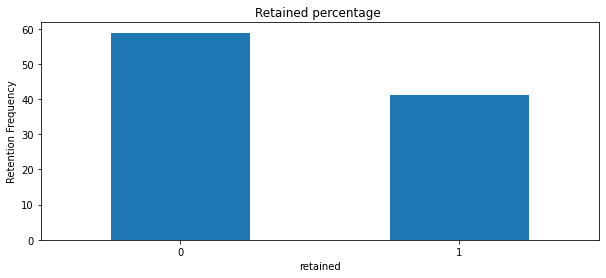

In [43]:
fig,ax = plt.subplots(figsize=[10,4])
count = df_NaN_free.shape[0]
df_active = (df_NaN_free.groupby('retained')['retained'].count()/count)*100
df_active.plot(kind='bar',ax=ax)
plt.ylabel('Retention Frequency')
plt.title('Retained percentage ');
plt.xticks(rotation=0);
df_active.head()

We have about 41% retained users in our dataset. Our data set is reasonably balanced and no need to worry about data imbalance issues. 

### Drop unncessary datetime features

In [44]:
# Drop datetime features
df_NaN_free.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

In [45]:
df_NaN_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41445 non-null  object 
 1   trips_in_first_30_days  41445 non-null  int64  
 2   avg_rating_of_driver    41445 non-null  float64
 3   avg_surge               41445 non-null  float64
 4   phone                   41445 non-null  object 
 5   surge_pct               41445 non-null  float64
 6   ultimate_black_user     41445 non-null  bool   
 7   weekday_pct             41445 non-null  float64
 8   avg_dist                41445 non-null  float64
 9   avg_rating_by_driver    41445 non-null  float64
 10  retained                41445 non-null  int32  
dtypes: bool(1), float64(6), int32(1), int64(1), object(2)
memory usage: 3.4+ MB


### One hot encode categorical features

In [46]:
df_NaN_free = pd.get_dummies(df_NaN_free, columns = ['city', 'phone', 'ultimate_black_user'], drop_first=True)

In [47]:
df_NaN_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   trips_in_first_30_days    41445 non-null  int64  
 1   avg_rating_of_driver      41445 non-null  float64
 2   avg_surge                 41445 non-null  float64
 3   surge_pct                 41445 non-null  float64
 4   weekday_pct               41445 non-null  float64
 5   avg_dist                  41445 non-null  float64
 6   avg_rating_by_driver      41445 non-null  float64
 7   retained                  41445 non-null  int32  
 8   city_King's Landing       41445 non-null  uint8  
 9   city_Winterfell           41445 non-null  uint8  
 10  phone_iPhone              41445 non-null  uint8  
 11  ultimate_black_user_True  41445 non-null  uint8  
dtypes: float64(6), int32(1), int64(1), uint8(4)
memory usage: 2.8 MB


In [48]:
df_NaN_free.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,1,0,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,0,0,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,0,0,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,1,0,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,0,0


# Modeling
## Separate features and target

In [49]:
X = df_NaN_free.drop('retained', axis=1)
y = df_NaN_free['retained']

## Train, test split data

In [50]:
from sklearn.model_selection import train_test_split,cross_validate, GridSearchCV, learning_curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33156, 11)
(8289, 11)
(33156,)
(8289,)


## Dummy Classifier
A good place to start is to see how good the most frequent class is as predictor. In other words, what if you simply say your best guess the most frequent driver retention class?

In [51]:
dumb_reg = DummyClassifier(strategy='most_frequent')
dumb_reg.fit(X_train, y_train)
dumb_reg.predict(X_test)
dumb_reg.score(X_test,y_test)

0.5818554711062854

A simple dummy model is 58% accurate. In what follows below we develop models with better accuracy than simple guess. 

## Initial base models

In [52]:
# define a function for generating modeles
def models(X_train,Y_train):
        #logistic regression
        from sklearn.linear_model import LogisticRegression
        #log = LogisticRegression(random_state=0)
        log = LogisticRegression()
        log.fit(X_train,y_train)
        log_cv_scores = cross_val_score(log,X_train, y_train, cv=5)
        #Decision tree
        from sklearn.tree import DecisionTreeClassifier
        #tree = DecisionTreeClassifier(criterion='entropy',random_state=0)
        tree = DecisionTreeClassifier()
        tree.fit(X_train,y_train)
        tree_cv_scores = cross_val_score(tree,X_train, y_train, cv=5)
        #Random Forest
        from sklearn.ensemble import RandomForestClassifier
        #forest = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
        forest = RandomForestClassifier()
        forest.fit(X_train,y_train)
        forest_cv_scores = cross_val_score(forest,X_train, y_train, cv=5)
        #print the models accuracy
        print('[0] Logistic Regressio: Average 5-Fold CV Score: {}'.format(np.mean(log_cv_scores)))
        print('[1] Decision Tree: Average 5-Fold CV Score: {}'.format(np.mean(tree_cv_scores)))
        print('[2] Random forest: Average 5-Fold CV Score: {}'.format(np.mean(forest_cv_scores)))   
        return log,tree,forest

model = models(X_train,y_train)

[0] Logistic Regressio: Average 5-Fold CV Score: 0.7047595240689681
[1] Decision Tree: Average 5-Fold CV Score: 0.6996623127944395
[2] Random forest: Average 5-Fold CV Score: 0.753679649938995


Using default parameters, random forest results to an accuracny of 75.34%. It resulted to better accuracy as compared to logistic regression and Decision tree. 

## Hyper parameter optimization of RF model

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
# define pipeline
RF_pipe = make_pipeline(
#    StandardScaler(),
   RandomForestClassifier(random_state=47)
)
#RF_pipe = RandomForestClassifier()

In [55]:
RF_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'randomforestclassifier', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [56]:
# Create hyper-parameter grid
#n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
n_est = [200,233]
#n_features = [4,6,8,10,11,'auto',None]
n_features = [4,'auto']

grid_params = {
        'randomforestclassifier__n_estimators': n_est,
        #'standardscaler': [StandardScaler(), None],
        'randomforestclassifier__max_features': n_features
}
grid_params

{'randomforestclassifier__n_estimators': [200, 233],
 'randomforestclassifier__max_features': [4, 'auto']}

In [57]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [58]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                           

In [59]:
rf_grid_cv.best_params_


{'randomforestclassifier__max_features': 4,
 'randomforestclassifier__n_estimators': 233}

It looks like the number of estimators helps, but the maximum features does not.

In [60]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.75407117, 0.75403408, 0.75071633, 0.75086714, 0.76157442])

In [61]:
np.mean(rf_best_scores)

0.7542526294323607

Marginal model accuracy improvement. 
It looks like hyper-parameter optimization does not help the accuracy of the model very much. 

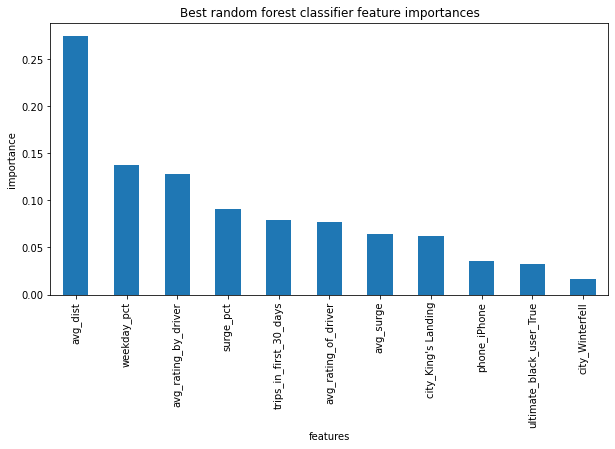

In [62]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestclassifier` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
#print(len(X_train.columns))
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
#print(imps)
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

As can be seen the most important features in determining user retention or not are: 
- `avg_dist`: the average distance in miles per trip taken in the first 30 days after signup
- `weekday_pct`: the percent of the user’s trips occurring during a weekday
- `avg_rating_by_driver`: the rider’s average rating over all of their trips

\textbf{Suggestions to Ultimate:} 

- To increase riders weekday trips (which probably happens as a means to go to work place or school), ultimate needs to decrease rider wait time.

- To envourage riders take more long distance trips, ultimate needs to improve on their car's cleanliness and comfort.

- To increase rider's average rating, ultimate needs to look into improving customer services and amenities.